<div style='background-color:#0071dc;text-align: center;padding:10px;'>
    <h1 style='color:white; font-family: Verdana'> <img alt='Walmart' src='https://i5.wal.co/dfw/63fd9f59-b3e1/7a569e53-f29a-4c3d-bfaf-6f7a158bfadd/v1/walmartLogo.svg'> Store Sales Forecasting </h1>
</div>

<h2 style='color:#ffc220; font-family: Verdana'> Imports </h2>

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
import zipfile
import time

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import randint, loguniform

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
import shap

In [ ]:
import datetime

<h2 style='color:#ffc220; font-family: Verdana'> Reading the files </h2>

<span style='color:#0071dc; font-family: Verdana'> Looping over all provided files. <span>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
filespath=r'/kaggle/input/walmart-recruiting-store-sales-forecasting/'

In [ ]:
files_list = [f for f in listdir(filespath) if isfile(join(filespath, f))]
print(files_list)

In [ ]:
dict_dfs={}
for file in files_list:
    if 'zip' in file:
        with zipfile.ZipFile(join(filespath, file),'r') as z:
            print(file)
            dict_dfs[file.split('.')[0]]=pd.read_csv(z.open('.'.join(file.split('.')[:2])))
    else:
        print(file)
        dict_dfs[file.split('.')[0]]=pd.read_csv(join(filespath, file))

In [ ]:
for name in dict_dfs:
    print(name)
    print(dict_dfs[name].head(),'\n')

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Two core datasets with weekly sales one for training one for testing.</li>
        <li>Features dataset to merge and bring extra row features.</li>
        <li>One stores dataset containing features per store number.</li>
    </ul>
</span>
<h5 style='color:gray; font-family: Verdana'>Decision here to try merging both feature datasets with both train and test datasets.</h5>

<h2 style='color:#ffc220; font-family: Verdana'> Exploratory Data Analysis </h2>

<h3 style='color:#0071dc; font-family: Verdana'> Merge with extra features dataset </h3>

<span style='color:#0071dc; font-family: Verdana'> Can the Features dataset be joined with train and test csv ? <span>

In [ ]:
df_trainoteste=pd.DataFrame(pd.concat([dict_dfs['train'],
dict_dfs['test']]))
df_trainoteste=pd.DataFrame(df_trainoteste.drop_duplicates(['Date','Store']).Date.str[2:7])
df_trainoteste['dataset']='Treino_e_teste'
df_featuresdates=pd.DataFrame(dict_dfs['features'].Date.str[2:7])
df_featuresdates['dataset']='Features'

In [ ]:
dfplotdatas=pd.concat([df_trainoteste,df_featuresdates])

In [ ]:
dfplotdatas=dfplotdatas.groupby(['Date','dataset'],as_index=False).agg(Date=('Date','last'),Count=('Date','count'),dataset=('dataset','last'))

In [ ]:
dfplotdatas.plot.bar(x='Date',y='Count',template='ggplot2',color="dataset",barmode='group',title='Merge features evaluation', color_discrete_sequence=["#ffc220", "#0071dc"],backend='plotly')

<span style='color:gray; font-family: Verdana'> By looking at date ranges for all the data sets we want to merge, the features data set has the necessary dates to merge withouts missings. <span>

<span style='color:#0071dc; font-family: Verdana'> Looking for the keys to join the datasets <span>

In [ ]:
dict_dfs['features'].head()

In [ ]:
dict_dfs['test'].head()

<span style='color:gray; font-family: Verdana'> Found both store and Date as keys to use to join. <span>

In [ ]:
dict_dfs['test']=dict_dfs['test'].merge(dict_dfs['features'],how='left',on=['Store','Date'])

In [ ]:
dict_dfs['train']=dict_dfs['train'].merge(dict_dfs['features'],how='left',on=['Store','Date'])

<span style='color:#0071dc; font-family: Verdana'> Seeing if the IsHoliday feature that repeat in both datasets are the same <span>

In [ ]:
dict_dfs['train'][dict_dfs['train']['IsHoliday_x']!=dict_dfs['train']['IsHoliday_y']]

In [ ]:
dict_dfs['test'][dict_dfs['test']['IsHoliday_x']!=dict_dfs['test']['IsHoliday_y']]

<span style='color:gray; font-family: Verdana'> IsHoliday is the same in both datasets, so one of the columns need to be droped <span>

In [ ]:
dict_dfs['test']=dict_dfs['test'].drop('IsHoliday_y',axis=1)

In [ ]:
dict_dfs['test']=dict_dfs['test'].rename(columns={'IsHoliday_x':'IsHoliday'})

In [ ]:
dict_dfs['train']=dict_dfs['train'].drop('IsHoliday_y',axis=1)

In [ ]:
dict_dfs['train']=dict_dfs['train'].rename(columns={'IsHoliday_x':'IsHoliday'})

<h3 style='color:#0071dc; font-family: Verdana'> Merge with extra store features </h3>

In [ ]:
dict_dfs['stores'].head()

In [ ]:
dict_dfs['train']=dict_dfs['train'].merge(dict_dfs['stores'],how='left',on='Store')

In [ ]:
dict_dfs['test']=dict_dfs['test'].merge(dict_dfs['stores'],how='left',on='Store')

<h3 style='color:#0071dc; font-family: Verdana'> Sales evaluations </h3>

In [ ]:
fig,ax=plt.subplots(figsize=(16, 8))
sns.histplot(dict_dfs['train']['Weekly_Sales'], color='#ffc220', bins=200,ax=ax,kde=True)
ax.set_xticks([i for i in range(0,700000,50000)])
ax.set_xlim([-10000,650000])
plt.show()

<span style='color:gray; font-family: Verdana'> Weekly sales are accumulated under 50k. <span>

In [ ]:
px.violin(dict_dfs['train'],x='Weekly_Sales', box=True)

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Weekly sales median is around 7500. </li>
        <li>Odd behavior of negative weekly sales, but with very low volume of events. </li>
        <li>Weekly Sales indeed accumulated on low values, with some outliers.</li>
    </ul>
<span>

<span style='color:#0071dc; font-family: Verdana'> Evaluating sales behavior over the year. <span>

In [ ]:
dfplot=dict_dfs['train']
dfplot['Week']=pd.to_datetime(dfplot.Date).dt.isocalendar().week
dfplot['Year']=pd.to_datetime(dfplot.Date).dt.isocalendar().year

In [ ]:
dfplot=dfplot.groupby(['Week','Year'],as_index=False).Weekly_Sales.mean()

In [ ]:
px.line(dfplot.sort_values(['Year','Week']),x='Week',title='Weekly sales X Years',y='Weekly_Sales',color='Year')

<span style='color:gray; font-family: Verdana'>The Weekly_Sales average is similar in all years, so there is no outlier year that we need to worry about..<span>

In [ ]:
dfplot=dict_dfs['train']
dfplot['Week']=pd.to_datetime(dfplot.Date).dt.isocalendar().week
dfplot=dfplot.groupby(['Week'],as_index=False).agg(Mean_Weekly_Sales=('Weekly_Sales','mean'))
# dfplot['Group']='Mean_Weekly_Sales'

In [ ]:
dfplot2=dict_dfs['train']
dfplot2['Week']=pd.to_datetime(dfplot2.Date).dt.isocalendar().week
dfplot2=dfplot2.groupby(['Week'],as_index=False).agg(Median_Weekly_Sales=('Weekly_Sales','median'))
# dfplot2['Group']='Median_Weekly_Sales'

In [ ]:
dfplotf=dfplot.merge(dfplot2,how='left',on='Week')

In [ ]:
px.line(dfplotf.sort_values(['Week']),x='Week',y=['Mean_Weekly_Sales','Median_Weekly_Sales'],title='Weekly sales: Mean X Median',color_discrete_sequence=['#ffb81c','#0072ce'])

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Mean and Median are distant from each other, that suggests there are some discrepancy between some stores and/or departments.</li>
        <li>Very near the end of the year the sales sky rocket twice, might be because of the holidays.</li>
        <li>Brief time before end of the year peak they actually fall, probably because of people saving to buy at the holidays.</li>
        <li>As the year starts the sales reach rock bottom, maybe because people spent too much on holidays and don't have more money to spend.</li>
    </ul>
   <span>
<h5>Decision here to create week feature to evaluate the holiday weeks and year too match the holidays if they chance by year.</h5>

In [ ]:
dict_dfs['train']['Week']=pd.to_datetime(dict_dfs['train'].Date).dt.isocalendar().week
dict_dfs['train']['Year']=pd.to_datetime(dict_dfs['train'].Date).dt.isocalendar().year

In [ ]:
dict_dfs['test']['Week']=pd.to_datetime(dict_dfs['test'].Date).dt.isocalendar().week
dict_dfs['test']['Year']=pd.to_datetime(dict_dfs['test'].Date).dt.isocalendar().year

<h3 style='color:#0071dc; font-family: Verdana'> Evaluating features </h3>

<span style='color:#0071dc; font-family: Verdana'> Evaluating column types and counts. <span>

In [ ]:
dict_dfs['train'].info()

In [ ]:
dict_dfs['train'].describe()

<span style='color:#0071dc; font-family: Verdana'> Evaluating null counts. <span>

In [ ]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(dict_dfs['train'].sort_values('Date').isna(),ax=ax,cbar=False,yticklabels=False,cmap=['#0071dc','white'])
plt.xticks(rotation=0)
plt.title('Missing values plot',fontdict={'fontsize':14,'fontfamily': 'Verdana'})
plt.tight_layout()
plt.show()

In [ ]:
dict_dfs['train'][(dict_dfs['train']['MarkDown1'].isna())&
                  (dict_dfs['train']['MarkDown2'].isna())&
                  (dict_dfs['train']['MarkDown3'].isna())&
                  (dict_dfs['train']['MarkDown4'].isna())&
                  (dict_dfs['train']['MarkDown5'].isna())].Date.str[:7].value_counts().sort_index()

In [ ]:
dict_dfs['train'][dict_dfs['train']['MarkDown1'].notna()].Date.min()

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>MarkDown columns have no values before 2011-11-11.</li>
        <li>Only markdown1 and markdown5 have no missing values.</li>
        <li>Markdown2 has a little bit more missings than the others.</li>
    </ul>
    <h5>Decision here might be to drop the markdowns for an MVP, but let's evaluate them further.</h5>
<span>

In [ ]:
fig,ax=plt.subplots(figsize=(18,8))
sns.heatmap(dict_dfs['test'].sort_values('Date').isna(),ax=ax,cbar=False,yticklabels=False,cmap=['#0071dc','white'])
plt.xticks(rotation=0)
plt.title('Missing values plot',fontdict={'fontsize':14,'fontfamily': 'Verdana'})
plt.tight_layout()
plt.show()

In [ ]:
print('Max date without nulls of CPI an Unemployment of the test dataset:',dict_dfs['test'][dict_dfs['test'].CPI.notna()].reset_index().Date.max())
print('Max date of the test dataset:',dict_dfs['test'].Date.max())
print('Percentage of nulls of CPI and Unemployment:',round(dict_dfs['test'][dict_dfs['test'].CPI.isna()].shape[0]*100/dict_dfs['test'].shape[0],2),'%')

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>That are a lot of missings of CPI and Unemplyment at the test dataset.</li>
        <li>That are no values of Unemployment and CPI after 26 of April 2013.</li>
    </ul>
<span>
<h5> Because of this quantity of missings of that features it might be suitable to drop them, even more because they have many missings afeter a certain period of time and not just reandom missings over the year so it would be hard to input them with like traditional rolling methods that work very well inputing missings for time series.</h5>

<span style='color:#0071dc; font-family: Verdana'> Evaluating the markdowns. <span>

<span style='color:gray; font-family: Verdana'> Markdowns are events of price reduction, so it is expected that the markdowns affect the sales. <span>

In [ ]:
dfplot=dict_dfs['train'][dict_dfs['train'].Date>='2011-11-11'].reset_index(drop=True).copy()
dfplot['Week']=pd.to_datetime(dfplot.Date).dt.isocalendar().week

In [ ]:
dfplot=dfplot[['Week','Weekly_Sales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].melt(id_vars=["Week"], 
        var_name="Variable", 
        value_name="Value")

In [ ]:
dfplot=dfplot.groupby(['Week','Variable'],as_index=False).mean()

In [ ]:
px.line(dfplot.sort_values('Week'),x='Week',title='Weekly sales X Markdowns',y='Value',color='Variable')

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Markdowns usually follows drops in sales, probably because the stores are trying to pump the sales back to the top.</li>
        <li>Shortly after markdowns there are some drops again, likely because people wait to buy on markdowns and than they wait for the next ones.</li>
        <li>Markdown columns affect a little bit the prices as seeing in the graph but the highest impacts are actually near the end of the year and as further evaluation that impact surely come from the holidays.</li>
    </ul>
<span>
<h5> Because Markdowns has too much missings and the strongest correlation that might be there, in fact is not most from this feature, it will be decided to drop them.</h5>

In [ ]:
dropmarks=[coluna for coluna in dict_dfs['features'].columns if 'markdown' in coluna.lower()]
dict_dfs['train'].drop(dropmarks,axis=1,inplace=True)
dict_dfs['test'].drop(dropmarks,axis=1,inplace=True)

<span style='color:#0071dc; font-family: Verdana'> Evaluating Holidays. <span>

In [ ]:
dict_holidays={'Super Bowl':  ['12-Feb-10', '11-Feb-11', '10-Feb-12', '08-Feb-13'],
'Labor Day':    ['10-Sep-10', '09-Sep-11', '07-Sep-12', '06-Sep-13'],
'Thanksgiving': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13'],
'Christmas':    ['31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13'],
#Adding relevant Holidays to evaluate their influence on sales
'Valentines Day': ['14-Feb-10', '14-Feb-11', '14-Feb-12', '14-Feb-13'],
'Mothers Day': ['09-May-10', '08-May-11', '13-May-12', '12-May-13'],
'Fathers Day': ['20-Jun-10', '19-Jun-11', '17-Jun-12', '16-Jun-13'],
'Easter': ['04-Apr-10', '24-Apr-11', '08-Apr-12', '31-Mar-13'],
'Black Friday': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13']}

In [ ]:
dict_holidays={i:[datetime.datetime.strptime(x,'%d-%b-%y') for x in dict_holidays[i]] for i in dict_holidays.keys()}

In [ ]:
dfplot=dict_dfs['train']
dfplot['Week']=pd.to_datetime(dfplot.Date).dt.isocalendar().week
dfplot['Year']=pd.to_datetime(dfplot.Date).dt.isocalendar().year
dfplot['Date']=pd.to_datetime(dfplot.Date)

In [ ]:
df_superbowl=pd.DataFrame(dict_holidays['Super Bowl'],columns=['Date']).merge(dfplot.groupby('Date',as_index=False).mean()[['Date','Weekly_Sales']],how='left')
df_laborday=pd.DataFrame(dict_holidays['Labor Day'],columns=['Date']).merge(dfplot.groupby('Date',as_index=False).mean()[['Date','Weekly_Sales']],how='left')
df_thanksgiving=pd.DataFrame(dict_holidays['Thanksgiving'],columns=['Date']).merge(dfplot.groupby('Date',as_index=False).mean()[['Date','Weekly_Sales']],how='left')
df_christmas=pd.DataFrame(dict_holidays['Christmas'],columns=['Date']).merge(dfplot.groupby('Date',as_index=False).mean()[['Date','Weekly_Sales']],how='left')

In [ ]:
df_ValentinesDay=pd.DataFrame([[i.isocalendar()[1],i.isocalendar()[0]] for i in dict_holidays['Valentines Day']],columns=['Week','Year']).merge(dfplot.groupby(['Week','Year'],as_index=False).agg({'Date':'last','Weekly_Sales':'mean'})[['Week','Year','Date','Weekly_Sales']],how='left')
df_MothersDay=pd.DataFrame([[i.isocalendar()[1],i.isocalendar()[0]] for i in dict_holidays['Mothers Day']],columns=['Week','Year']).merge(dfplot.groupby(['Week','Year'],as_index=False).agg({'Date':'last','Weekly_Sales':'mean'})[['Week','Year','Date','Weekly_Sales']],how='left')
df_FathersDay=pd.DataFrame([[i.isocalendar()[1],i.isocalendar()[0]] for i in dict_holidays['Fathers Day']],columns=['Week','Year']).merge(dfplot.groupby(['Week','Year'],as_index=False).agg({'Date':'last','Weekly_Sales':'mean'})[['Week','Year','Date','Weekly_Sales']],how='left')
df_Easter=pd.DataFrame([[i.isocalendar()[1],i.isocalendar()[0]] for i in dict_holidays['Easter']],columns=['Week','Year']).merge(dfplot.groupby(['Week','Year'],as_index=False).agg({'Date':'last','Weekly_Sales':'mean'})[['Week','Year','Date','Weekly_Sales']],how='left')
df_BlackFriday=pd.DataFrame([[i.isocalendar()[1],i.isocalendar()[0]] for i in dict_holidays['Black Friday']],columns=['Week','Year']).merge(dfplot.groupby(['Week','Year'],as_index=False).agg({'Date':'last','Weekly_Sales':'mean'})[['Week','Year','Date','Weekly_Sales']],how='left')

In [ ]:
fig,ax=plt.subplots(figsize=(22,6))
sns.lineplot(data=dfplot,x='Date',y='Weekly_Sales',color='#ffc220',ax=ax,label='Weekly_Sales')
ax.set_ylabel('Weekly_Sales')
ax.vlines(dfplot[dfplot.IsHoliday==True].groupby('Date',as_index=False).mean().Date,dfplot[dfplot.IsHoliday==True].groupby('Date',as_index=False).mean().Weekly_Sales.min()-1000,dfplot[dfplot.IsHoliday==True].groupby('Date',as_index=False).mean().Weekly_Sales.max()+1000,label='IsHoliday', linestyles='dashed', color='skyblue')
ax.vlines(df_BlackFriday.Date,df_BlackFriday.Weekly_Sales.min()-1000,df_BlackFriday.Weekly_Sales.max()+1000,label='Black Friday', linestyles='dashed', colors='dimgray')
# sns.scatterplot(data=dfplot[dfplot.IsHoliday==True].groupby('Date',as_index=False).mean(),x='Date',y='Weekly_Sales', marker='o', s=100,label='IsHoliday',ax=ax)
sns.scatterplot(data=df_superbowl,x='Date',y='Weekly_Sales', marker='o', s=100,label='Super Bowl',ax=ax)
sns.scatterplot(data=df_laborday,x='Date',y='Weekly_Sales', marker='o', s=100,label='Labor Day',ax=ax)
sns.scatterplot(data=df_thanksgiving,x='Date',y='Weekly_Sales', marker='o', s=100,label='Thanks Giving',ax=ax)
sns.scatterplot(data=df_christmas,x='Date',y='Weekly_Sales', marker='o', s=100,label='Christmas',ax=ax)
sns.scatterplot(data=df_ValentinesDay,x='Date',y='Weekly_Sales', marker='o', s=100,label='Valentines Day',ax=ax)
sns.scatterplot(data=df_MothersDay,x='Date',y='Weekly_Sales', marker='o', s=100,label='Mothers Day',ax=ax)
sns.scatterplot(data=df_FathersDay,x='Date',y='Weekly_Sales', marker='o', s=100,label='Fathers Day',ax=ax)
sns.scatterplot(data=df_Easter,x='Date',y='Weekly_Sales', marker='o', s=100,label='Easter',ax=ax)
plt.legend()
locator = mdates.AutoDateLocator(minticks=12, maxticks=24)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('Holiday plot')
plt.show()

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>It is possible to notice that at Thanks Giving and Super Bowl that are rises in sales but after that, they plummet.</li>
        <li>Also before Christmas that are huge rises too but at the holiday, they already hit rock bottom different from the other two.</li>
        <li>The only one that doesn not reflect too much on rising sales is Labor Day, but as the other three after the holiday it falls a bit.</li>
        <li>Best insight to focus is that both Thanks Giving and Christmas has a lot of impact on sales.</li>
        <li>All Holidays that appears on IsHoliday are actually in the holliday dates in the exercise description.</li> 
        <li>All Holidays manually added holidays except fathers day are at some peak sales of the month.</li> 
        <li>Black Friday matches Thanks Giving, so no need to add it.</li> 
    </ul>
<span>
    <h5> Decision here to add new holidays except Black Friday and use some kind of flag too see the sales before and after holidays.</h5>

In [ ]:
dict_holidays.pop('Black Friday')

In [ ]:
for holiday in dict_holidays.keys():
    dict_dfs['train'][holiday]=0
    holbefcol=holiday+'_before'
    dict_dfs['train'][holbefcol]=0
    holaftcol=holiday+'_aft'
    dict_dfs['train'][holaftcol]=0
    dfholidaytemp=pd.Series(dict_holidays[holiday]).dt.isocalendar().iloc[:,:2]
    dfholidaytempbef=(pd.Series(dict_holidays[holiday])-pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
    dfholidaytempaft=(pd.Series(dict_holidays[holiday])+pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
    for nmr in range(len(dfholidaytemp)):
        dict_dfs['train'].loc[(dict_dfs['train'].Week==dfholidaytemp.iloc[nmr,1])&(dict_dfs['train'].Year==dfholidaytemp.iloc[nmr,0]),holiday]=1
        
        dict_dfs['train'].loc[(dict_dfs['train'].Week==dfholidaytempbef.iloc[nmr,1])&(dict_dfs['train'].Year==dfholidaytempbef.iloc[nmr,0]),holbefcol]=1
        
        dict_dfs['train'].loc[(dict_dfs['train'].Week==dfholidaytempaft.iloc[nmr,1])&(dict_dfs['train'].Year==dfholidaytempaft.iloc[nmr,0]),holaftcol]=1

In [ ]:
for holiday in dict_holidays.keys():
    dict_dfs['test'][holiday]=0
    holbefcol=holiday+'_before'
    dict_dfs['test'][holbefcol]=0
    holaftcol=holiday+'_aft'
    dict_dfs['test'][holaftcol]=0
    dfholidaytemp=pd.Series(dict_holidays[holiday]).dt.isocalendar().iloc[:,:2]
    dfholidaytempbef=(pd.Series(dict_holidays[holiday])-pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
    dfholidaytempaft=(pd.Series(dict_holidays[holiday])+pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
    for nmr in range(len(dfholidaytemp)):
        dict_dfs['test'].loc[(dict_dfs['test'].Week==dfholidaytemp.iloc[nmr,1])&(dict_dfs['test'].Year==dfholidaytemp.iloc[nmr,0]),holiday]=1
        
        dict_dfs['test'].loc[(dict_dfs['test'].Week==dfholidaytempbef.iloc[nmr,1])&(dict_dfs['test'].Year==dfholidaytempbef.iloc[nmr,0]),holbefcol]=1
        
        dict_dfs['test'].loc[(dict_dfs['test'].Week==dfholidaytempaft.iloc[nmr,1])&(dict_dfs['test'].Year==dfholidaytempaft.iloc[nmr,0]),holaftcol]=1

In [ ]:
dict_dfs['test']

<span style='color:#0071dc; font-family: Verdana'> Hist plots <span>

In [ ]:
dict_dfs['train'][dict_dfs['train'].columns[dict_dfs['train'].dtypes!='object']].iloc[:,:10].hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8,color='#6cace4')
plt.tight_layout()
plt.show()

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Some variables are very far for normal distributions.</li>
    </ul>
<span>
    <h5> Decision here to not use lienar regressors as it would be hard to normalize the variables and mayba not use some of them.</h5>

<span style='color:#0071dc; font-family: Verdana'> Seeing correlation with target. <span>

In [ ]:
for i in range(0, len(dict_dfs['train'][dict_dfs['train'].columns[dict_dfs['train'].dtypes!='object']].drop(['Weekly_Sales','Date'],axis=1).columns), 3):
    sns.pairplot(data=dict_dfs['train'][dict_dfs['train'].columns[dict_dfs['train'].dtypes!='object']],
                x_vars=dict_dfs['train'][dict_dfs['train'].columns[dict_dfs['train'].dtypes!='object']].drop(['Weekly_Sales','Date'],axis=1).columns[i:i+3],
                y_vars=['Weekly_Sales'],
                 
                 plot_kws={'color': '#6cace4'},height=3,aspect=1.8)
plt.tight_layout()

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>It is possible to notice that some variables like temperature and IsHolliday have the biggest sales accumulated at some ranges, but not much of linear relationships.</li>
        <li>Also the flags created for the holidays shows a little bit of difference in the distribution, most clear to see are after christmas and at Thanksgiving
    </ul>
<span>
    <h5> Decision here to maintain Holiday flags.</h5>

In [ ]:
dict_dfs['train'].IsHoliday=dict_dfs['train'].IsHoliday.astype(int)
dict_dfs['test'].IsHoliday=dict_dfs['test'].IsHoliday.astype(int)

<span style='color:#0071dc; font-family: Verdana'> Seeing Pearson's linear correlation with target. <span>

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
sns.heatmap(dict_dfs['train'].corr(),cmap='YlGnBu',annot=True, fmt=".0%")
plt.show()

<span style='color:gray; font-family: Verdana'>
    <ul>
        <li>Size is the variable that has a little bit more of linear correlation with the Sales target and it makes sense because, usually the bigger the store is, more sales they have.</li>
        <li>CPI and Unemployment has not very much correlation with Weekly_Sales
    </ul>
<span>
    <h5> As seen in the missings plot and on the analysis above it will be decided to drop CPI and Unemployment.</h5>
<span style='color:gray; font-family: Verdana'>  <span>

In [ ]:
dict_dfs['train']=dict_dfs['train'].drop(['CPI', 'Unemployment'],axis=1)
dict_dfs['test']=dict_dfs['test'].drop(['CPI', 'Unemployment'],axis=1)

<span style='color:#0071dc; font-family: Verdana'> Plotting categorical Store Type variable. <span>

In [ ]:
fig,ax=plt.subplots(figsize = (16, 8))
sns.stripplot(x='Type', y='Weekly_Sales', data=dict_dfs['train'],ax=ax,size=5,jitter=True,alpha=0.5)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.show()

<span style='color:gray; font-family: Verdana'> B has the highest weekly sales, A comes next and C has the least high weekly sales. <span>

In [ ]:
fig,ax=plt.subplots(figsize = (16, 12))
sns.stripplot(y='Type', x='Weekly_Sales', data=dict_dfs['train'],ax=ax,size=6,jitter=True,alpha=0.01)
sns.violinplot(y='Type', x='Weekly_Sales', data=dict_dfs['train'],ax=ax)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
ax.set_xticks([i for i in range(-10000,100000,5000)])
ax.set_xlim([-10000,100000])
plt.show()

<span style='color:gray; font-family: Verdana'> Looking at density, store types A and B are similar, but store A have a little bit more accumulated high weekly sales counts and store B have some outliers of high weekly sales. Store C have more low weekly sales accumulation. 
    <span>
            <h5 style='color:gray; font-family: Verdana'>Therefore store type may help us determine weekly sales.</h5>

In [ ]:
dict_dfs['train']=dict_dfs['train'].join(pd.get_dummies(dict_dfs['train'].Type))
dict_dfs['train']=dict_dfs['train'].drop('Type',axis=1)
dict_dfs['test']=dict_dfs['test'].join(pd.get_dummies(dict_dfs['test'].Type))
dict_dfs['test']=dict_dfs['test'].drop('Type',axis=1)

<span style='color:#0071dc; font-family: Verdana'> Plotting Stores vs Departments. <span>

In [ ]:
px.scatter(dict_dfs['train'],x='Dept',y='Store',title='Stores X Departments',color='Size',color_continuous_scale=px.colors.sequential.Bluyl)

In [ ]:
fig=px.bar(dict_dfs['train'].groupby('Store',as_index=False).agg({'Dept':'nunique','Size':'last'}),x='Store',y='Dept',title='Stores X Departments',color='Size',color_continuous_scale=px.colors.sequential.Bluyl)
fig.update_layout(
xaxis_type = 'category'
)
fig.update_xaxes(categoryorder='array', categoryarray=dict_dfs['train'].groupby('Store',as_index=False).agg({'Dept':'nunique','Size':'last'}).sort_values('Size').Store.to_list())
fig.show()

<span style='color:gray; font-family: Verdana'> As seen above the smallest stores seems to have the least number of departments and not all sotres have all departments. <span>

<span style='color:#0071dc; font-family: Verdana'> Plotting departments average week sales. <span>

In [ ]:
df_plot_depts=dict_dfs['train'].groupby('Dept')['Weekly_Sales'].mean().reset_index()
df_plot_depts.Dept=df_plot_depts.Dept.astype(str)

In [ ]:
px.bar(df_plot_depts,x='Dept',y='Weekly_Sales',color='Dept',color_discrete_sequence=px.colors.qualitative.Vivid)

<span style='color:gray; font-family: Verdana'> Some departments average more sales than others. <span>

<span style='color:#0071dc; font-family: Verdana'> Plotting stores average of week sales. <span>

In [ ]:
df_plot_stores=dict_dfs['train'].groupby('Store')['Weekly_Sales'].mean().reset_index()
df_plot_stores.Store=df_plot_stores.Store.astype(str)

In [ ]:
px.bar(df_plot_stores,x='Store',y='Weekly_Sales',color='Store',color_discrete_sequence=px.colors.qualitative.Vivid)

<span style='color:gray; font-family: Verdana'> There are clearly stores with more average sales than others. <span>
        <h5 style='color:gray; font-family: Verdana'>So Department and store number can be useful to predict weekly sales.</h5>

<h2 style='color:#ffc220; font-family: Verdana'> Handling the models </h2>

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import  OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.metrics import make_scorer,mean_absolute_error
from boruta import BorutaPy

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

<h4 style='color:#0071dc; font-family: Verdana'> Reading again the datasets but this time for the models</h4>

In [ ]:
with zipfile.ZipFile(join(filespath, 'train.csv.zip'),'r') as z:
    train=pd.read_csv(z.open('train.csv'))
with zipfile.ZipFile(join(filespath, 'test.csv.zip'),'r') as z:
    test=pd.read_csv(z.open('test.csv'))
with zipfile.ZipFile(join(filespath, 'features.csv.zip'),'r') as z:
    features=pd.read_csv(z.open('features.csv'))
stores=pd.read_csv(join(filespath, 'stores.csv'))

<h4 style='color:#0071dc; font-family: Verdana'> Merging datasets for the models</h4>

In [ ]:
train=train.merge(features,how='left',on=['Store','Date','IsHoliday'])
train=train.merge(stores,how='left',on=['Store'])

In [ ]:
test=test.merge(features,how='left',on=['Store','Date','IsHoliday'])
test=test.merge(stores,how='left',on=['Store'])

<h4 style='color:#0071dc; font-family: Verdana'> Making pipelines for the predictions</h4>

<h5 style='color:#ffc220; font-family: Verdana'> Pipeline for numerics </h5>

In [ ]:
numerics = train.columns[((train.dtypes == 'float64')|(train.dtypes == 'int64'))&(train.columns!='Weekly_Sales')&(train.columns!='Store')&(train.columns!='Dept')]
numerics=list(numerics.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment']))

In [ ]:
numerics

In [ ]:
pipe_numerics = make_pipeline(
    SimpleImputer(strategy='mean'),
#     StandardScaler()
)

<span style='color:gray; font-family: Verdana'> Inputing the median as filling the empty values, because we don't want to be affected by outliers using like the average, using the standard scaler is not necessary for tree models but it is necessary to use with a linear regression baseline model if we want to test it </span>

<h5 style='color:#ffc220; font-family: Verdana'> Pipeline for categoricals </h5>

<span style='color:gray; font-family: Verdana'>Store dept and type are actually categories and so it would be better to rank them if we want to use them as numerics so dicts will be created ranking them by weekly sales</span>

In [ ]:
df_test=train.groupby('Store',as_index=False).Weekly_Sales.mean().sort_values('Weekly_Sales',ascending=False).drop('Weekly_Sales',axis=1)
df_test=df_test.reset_index(drop=True).reset_index()

In [ ]:
{int(i.split(':')[0]):int(i.split(':')[1]) for i in list(df_test.Store.astype(str)+':'+df_test.index.astype(str))}

In [ ]:
df_test=train.groupby('Type',as_index=False).Weekly_Sales.mean().sort_values('Weekly_Sales',ascending=False).drop('Weekly_Sales',axis=1)
df_test=df_test.reset_index(drop=True).reset_index()

In [ ]:
{i.split(':')[0]:int(i.split(':')[1]) for i in list(df_test.Type.astype(str)+':'+df_test.index.astype(str))}

In [ ]:
df_test=train.groupby('Dept',as_index=False).Weekly_Sales.mean().sort_values('Weekly_Sales',ascending=False).drop('Weekly_Sales',axis=1)
df_test=df_test.reset_index(drop=True).reset_index()

In [ ]:
{int(i.split(':')[0]):int(i.split(':')[1]) for i in list(df_test.Dept.astype(str)+':'+df_test.index.astype(str))}

In [ ]:
class Store_dept_type(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dict_dept={92: 0, 95: 1, 38: 2, 72: 3, 65: 4, 90: 5, 40: 6, 2: 7, 91: 8, 94: 9, 13: 10, 8: 11, 93: 12, 4: 13, 7: 14, 23: 15, 79: 16, 5: 17, 9: 18, 46: 19, 1: 20, 10: 21, 34: 22, 81: 23, 82: 24, 96: 25, 14: 26, 11: 27, 97: 28, 16: 29, 74: 30, 87: 31, 80: 32, 3: 33, 22: 34, 55: 35, 17: 36, 25: 37, 49: 38, 26: 39, 67: 40, 18: 41, 32: 42, 98: 43, 33: 44, 24: 45, 71: 46, 29: 47, 20: 48, 42: 49, 21: 50, 6: 51, 44: 52, 12: 53, 30: 54, 56: 55, 58: 56, 83: 57, 37: 58, 35: 59, 50: 60, 31: 61, 85: 62, 36: 63, 41: 64, 52: 65, 19: 66, 27: 67, 48: 68, 59: 69, 28: 70, 99: 71, 60: 72, 77: 73, 54: 74, 45: 75, 51: 76, 39: 77, 78: 78, 43: 79, 47: 80}
        dict_type={'A': 0, 'B': 1, 'C': 2}
        dict_stores={20: 0,  4: 1,  14: 2,  13: 3,  2: 4,  10: 5,  27: 6,  6: 7,  1: 8,  39: 9,  19: 10,  23: 11,  31: 12,  11: 13,  24: 14,  28: 15,  41: 16,  32: 17,  18: 18,  22: 19,  12: 20,  26: 21,  35: 22,  40: 23,  34: 24,  43: 25,  8: 26,  17: 27,  45: 28,  42: 29,  21: 30,  25: 31,  37: 32,  15: 33,  9: 34,  30: 35,  36: 36,  7: 37,  29: 38,  16: 39,  38: 40,  3: 41,  44: 42,  33: 43,  5: 44}
        dfz=X.copy(deep=True)
        dfz.Store=dfz.Store.replace(dict_stores)
        dfz.Dept=dfz.Dept.replace(dict_dept)
        dfz.Type=dfz.Type.replace(dict_type)
        return dfz

In [ ]:
categoricals = train.columns[train.columns.isin(['Store','Dept','Type'])]

In [ ]:
pipe_cats = make_pipeline(
    Store_dept_type()
)

<h5 style='color:#ffc220; font-family: Verdana'> Pipeline for Date </h5>

In [ ]:
class Date_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dict_holidays={
        'Super Bowl':  ['12-Feb-10', '11-Feb-11', '10-Feb-12', '08-Feb-13'],
#         'Labor Day':    ['10-Sep-10', '09-Sep-11', '07-Sep-12', '06-Sep-13'],
        'Thanksgiving': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13'],
        'Christmas':    ['31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13'],
        'Valentines Day': ['14-Feb-10', '14-Feb-11', '14-Feb-12', '14-Feb-13'],
#         'Mothers Day': ['09-May-10', '08-May-11', '13-May-12', '12-May-13'],
        'Fathers Day': ['20-Jun-10', '19-Jun-11', '17-Jun-12', '16-Jun-13'],
        'Easter': ['04-Apr-10', '24-Apr-11', '08-Apr-12', '31-Mar-13'],
#         'Black Friday': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13']
        }
        dict_holidays={i:[datetime.datetime.strptime(x,'%d-%b-%y') for x in dict_holidays[i]] for i in dict_holidays.keys()}
        dfz=X.copy(deep=True)
        dfz["Week"] = pd.to_datetime(dfz.Date).dt.isocalendar().week
        dfz["Year"] = pd.to_datetime(dfz.Date).dt.isocalendar().year
        dfz["Month"] = pd.to_datetime(dfz.Date).dt.month
        dfz["Day"] = pd.to_datetime(dfz.Date).dt.day
        for holiday in dict_holidays.keys():
            dfz[holiday]=0
#             holbefcol=holiday+'_before'
#             dfz[holbefcol]=0
#             holaftcol=holiday+'_aft'
#             dfz[holaftcol]=0
            dfholidaytemp=pd.Series(dict_holidays[holiday]).dt.isocalendar().iloc[:,:2]
#             dfholidaytempbef=(pd.Series(dict_holidays[holiday])-pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
#             dfholidaytempaft=(pd.Series(dict_holidays[holiday])+pd.Timedelta(weeks=1)).dt.isocalendar().iloc[:,:2]
            for nmr in range(len(dfholidaytemp)):
                dfz.loc[(dict_dfs['train'].Week==dfholidaytemp.iloc[nmr,1])&(dfz.Year==dfholidaytemp.iloc[nmr,0]),holiday]=1

#                 dfz.loc[(dict_dfs['train'].Week==dfholidaytempbef.iloc[nmr,1])&(dfz.Year==dfholidaytempbef.iloc[nmr,0]),holbefcol]=1

#                 dfz.loc[(dict_dfs['train'].Week==dfholidaytempaft.iloc[nmr,1])&(dfz.Year==dfholidaytempaft.iloc[nmr,0]),holaftcol]=1
        return dfz.drop('Date',axis=1)

In [ ]:
dict_holidays={
    'Super Bowl':  ['12-Feb-10', '11-Feb-11', '10-Feb-12', '08-Feb-13'],
# 'Labor Day':    ['10-Sep-10', '09-Sep-11', '07-Sep-12', '06-Sep-13'],
'Thanksgiving': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13'],
'Christmas':    ['31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13'],
'Valentines Day': ['14-Feb-10', '14-Feb-11', '14-Feb-12', '14-Feb-13'],
# 'Mothers Day': ['09-May-10', '08-May-11', '13-May-12', '12-May-13'],
'Fathers Day': ['20-Jun-10', '19-Jun-11', '17-Jun-12', '16-Jun-13'],
'Easter': ['04-Apr-10', '24-Apr-11', '08-Apr-12', '31-Mar-13'],
# 'Black Friday': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13']
}
dict_holidays={i:[datetime.datetime.strptime(x,'%d-%b-%y') for x in dict_holidays[i]] for i in dict_holidays.keys()}
list_columns_date=[]
list_columns_date.append('Week')
list_columns_date.append('Year')
list_columns_date.append('Month')
list_columns_date.append('Day')
X=train.copy(deep=True)
X["Week"] = pd.to_datetime(X.Date).dt.isocalendar().week
X["Year"] = pd.to_datetime(X.Date).dt.isocalendar().year
for holiday in dict_holidays.keys():
#     holbefcol=holiday+'_before'
#     holaftcol=holiday+'_aft'
    list_columns_date.append(holiday)
#     list_columns_date.append(holbefcol)
#     list_columns_date.append(holaftcol)

In [ ]:
pipe_date = make_pipeline(
    Date_Transformer()
)

<h5 style='color:#ffc220; font-family: Verdana'> Pipe bools</h5>

In [ ]:
bools = train.columns[(train.dtypes == bool)]

In [ ]:
class bool_transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dfz=X.copy(deep=True)
        dfz=dfz.astype(int)
        return dfz

In [ ]:
pipe_bools = make_pipeline(
    bool_transformer()
)

<h5 style='color:#ffc220; font-family: Verdana'> Merge Pipelines</h5>

In [ ]:
pipe_prep =make_column_transformer(
    (pipe_numerics, numerics),
    (pipe_cats, categoricals),
    (pipe_date, ['Date']),
    (pipe_bools, bools)
)

<h4 style='color:#0071dc; font-family: Verdana'> Creating the evaluating methods</h4>

<h5 style='color:#ffc220; font-family: Verdana'> Creating the weighted mean average as suggested by the exercise description</h5>

<span style='color:gray; font-family: Verdana'> Matric for the train X test evaluation<span>

In [ ]:
def Custom_WMAE(weights, y_true,y_pred):
    return np.average(np.abs(y_true - y_pred), weights=weights, axis=0)

<span style='color:gray; font-family: Verdana'> Metric for the crossvalidation score when tuning the parameters</span>

In [ ]:
def Custom_WMAE_train(y_true,y_pred):
    return np.average(np.abs(y_true - y_pred), weights=train.iloc[y_true.index].IsHoliday.astype(int)*4+1, axis=0)
Custom_WMAE_train_scorer=make_scorer(Custom_WMAE_train)

<h5 style='color:#ffc220; font-family: Verdana'> Train test split </h5>

<span style='color:gray; font-family: Verdana'> Divinding the dataset in train and test by 'out-of-time' method, it means the train have a range of dates and the test another range, since in crossvalidation we already uses the other commonly used method 'out-of-sample'. <span>

In [ ]:
train.Date.astype(str).str[:7].value_counts().sort_index()

<span style='color:gray; font-family: Verdana'> As 2012 doesn't have the last weeks of the year that are very important and 2010 doesn't have the start of the year, the decision will be to split 2010 and 2011 until october for training and the rest for testing<span>

In [ ]:
pd.to_datetime(train[pd.to_datetime(train.Date).dt.isocalendar().year==2012].Date).dt.isocalendar().week.max()

In [ ]:
train[(pd.to_datetime(train.Date).dt.isocalendar().year==2011)&(pd.to_datetime(train.Date).dt.isocalendar().week==43)].Date

In [ ]:
X_train=pipe_prep.fit_transform(train[train.Date<='2012-07'].drop('Weekly_Sales',axis=1))

In [ ]:
X_test=pipe_prep.transform(train[train.Date>'2012-07'].drop('Weekly_Sales',axis=1))

In [ ]:
y_train=train[train.Date<='2012-07']['Weekly_Sales']
y_test=train[train.Date>'2012-07']['Weekly_Sales']

In [ ]:
X_train_raw=train[train.Date<='2012-07'].drop('Weekly_Sales',axis=1)
X_test_raw=train[train.Date>'2012-07'].drop('Weekly_Sales',axis=1)

In [ ]:
X_train_weights=train[train.Date<='2012-07'].IsHoliday.astype(int)*4+1
X_test_weights=train[train.Date>'2012-07'].IsHoliday.astype(int)*4+1

<h5 style='color:#ffc220; font-family: Verdana'> Function to test models </h5>

In [ ]:
dict_models={'lgbm':LGBMRegressor(n_jobs=-1,random_state=42),
             'rf':RandomForestRegressor(n_jobs=-1,random_state=42),
             'xgb':XGBRegressor(n_jobs=-1,random_state=42),
             'en':ElasticNet(random_state=42),
             'lr':LinearRegression(n_jobs=-1)}

<span style='color:gray; font-family: Verdana'> Function to test models without tuning the hyperparameters<span>

In [ ]:
def models_baseline_evaluation(model,X_train,y_train,X_test,y_test,X_train_weights,X_test_weights):
    start_time = time.time()
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    wmae_train=Custom_WMAE(X_train_weights,y_train,y_pred_train)
    wmae_test=Custom_WMAE(X_test_weights,y_test,y_pred_test)
    return print('Model:',str(model).split('(')[0],'Train Score:',wmae_train,'Test Score:',wmae_test,'Time:', (time.time() - start_time),'seconds')

<span style='color:gray; font-family: Verdana'> Function to test models with tuning the hyperparameters<span>

In [ ]:
def models_with_tuning_evaluation(model,param,X_train,y_train,X_test,y_test,X_train_weights,X_test_weights):

    kfold = KFold(n_splits=3)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions= random_grid,
        cv = kfold,
        verbose = 10,
        n_iter=30,
        n_jobs=1,
        return_train_score=True,
        scoring=Custom_WMAE_train_scorer)
    
    random_search.fit(X_train, y_train)
    df_results_cv=pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score')
    df_results_cv['Overfit']=df_results_cv.mean_train_score/df_results_cv.mean_test_score
    new_params=df_results_cv[(df_results_cv['Overfit']>0.5)&(df_results_cv['Overfit']<1)].iloc[0].params
    testscore=df_results_cv[(df_results_cv['Overfit']>0.5)&(df_results_cv['Overfit']<1)].iloc[0].mean_test_score
    trainscore=df_results_cv[(df_results_cv['Overfit']>0.5)&(df_results_cv['Overfit']<1)].iloc[0].mean_train_score
    model.set_params=new_params
    model.fit(X_train,y_train)
    
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    
    wmae_train=Custom_WMAE(X_train_weights,y_train,y_pred_train)
    wmae_test=Custom_WMAE(X_test_weights,y_test,y_pred_test)
    
    return trainscore,testscore ,df_results_cv

<span style='color:gray; font-family: Verdana'> Function plot the models X the true values<span>

In [ ]:
def model_evaluator(model,name):
    model_train_predict=model.predict(X_train_raw)
    model_test_predict=model.predict(X_test_raw)
    print('Train WMAE:',Custom_WMAE(X_train_weights, y_train, model_train_predict))
    print('Test WMAE:',Custom_WMAE(X_test_weights, y_test, model_test_predict))
    model_predicted_week_sales=pd.DataFrame(list(model_train_predict)+list(model_test_predict),columns=[f'Weekly_Sales_{name}'])
    df_plot=pd.concat([train[['Date','Weekly_Sales']],model_predicted_week_sales],axis=1)
    df_plot=df_plot.groupby('Date',as_index=False).mean()
    return px.line(df_plot,x='Date',title=f'Weekly sales X Weekly sales {name} predicted',y=['Weekly_Sales',f'Weekly_Sales_{name}'])

In [ ]:
def plot_feature_importance(model):
    features=[x for i in model.named_steps['prep'].get_params()['transformers'] for x  in list(i[2]) ]
    features.remove('Date')
    features=features+list_columns_date+['IsHoliday']
    features.remove('IsHoliday')
    return px.bar(pd.DataFrame(model['model'].feature_importances_,index=features,columns=['FI']).sort_values('FI',ascending=False),orientation='h',)

<h4 style='color:#0071dc; font-family: Verdana'> Evaluating models</h4>

<h5 style='color:#ffc220; font-family: Verdana'> Evaluating baselines</h5>

In [ ]:
for model in dict_models.keys():
    models_baseline_evaluation(dict_models[model],X_train,y_train,X_test,y_test,X_train_weights,X_test_weights)

<span style='color:gray; font-family: Verdana'> As said before, the linear models did not predict very well our target, probably because we do not have many strong linear relationships. Also, XGBRegressor and RandomForest are slow to test so would be hard to do the tuning.
Decision here to focus on the LGBMRegressor as an MVP.<span>

<h5 style='color:#ffc220; font-family: Verdana'> Evaluating models with tuning search </h5>

<span style='color:#0071dc; font-family: Verdana'> Random Search for hyperparameters tuning for the Lgbm<span>

In [ ]:
n_estimators = [30,50,100]
num_leaves = [int(x) for x in range(20, 100,15)]
colsample_bytree = [i/10 for i in range(7, 10, 1)]
learning_rate = [i/10 for i in range(2, 8, 1)]
reg_alpha= [0]
reg_lambda= [1]
subsample= [0.65,0.75,0.9]

random_grid = {
'n_estimators': n_estimators,
'num_leaves': num_leaves,
'colsample_bytree' : colsample_bytree,
'learning_rate' :learning_rate,
'reg_alpha': reg_alpha,
 'reg_lambda': reg_lambda,
 'subsample':subsample,
}

In [ ]:
trainscore_lgb,testscore_lgb,df_results_cv_lgb=models_with_tuning_evaluation(dict_models['lgbm'],random_grid,X_train,y_train,X_test,y_test,X_train_weights,X_test_weights)

In [ ]:
df_results_cv_lgb.sort_values("mean_train_score")

<span style='color:#0071dc; font-family: Verdana'> Fiting the best overfit x performance model <span>

In [ ]:
df_results_cv_lgb.sort_values("mean_train_score").iloc[0].params

In [ ]:
df_results_cv_lgb.sort_values("Overfit",ascending=False).iloc[0].params

In [ ]:
lgb=LGBMRegressor(random_state=42,n_jobs=-1, subsample= 0.65, reg_lambda= 1, reg_alpha= 0, n_estimators= 100, num_leaves= 95, learning_rate = 0.6, colsample_bytree= 0.8) 

In [ ]:
pkl_lgb=Pipeline(steps=[('prep',pipe_prep),('model',lgb)])

In [ ]:
pkl_lgb.fit(X_train_raw,y_train)

<span style='color:#0071dc; font-family: Verdana'> Evaluating the model<span>

In [ ]:
model_evaluator(pkl_lgb,'LightGBM')

<span style='color:gray; font-family: Verdana'> It is possible to see that the model has a lot of bias and need some more variance maybe overfit a little bit more, even though it is possible to notice that there are some little peaks at some expected places like at thanksgiving, but time is not enough to do that.<span>

<span style='color:#0071dc; font-family: Verdana'> Evaluating the importance of the features by the model.<span>

In [ ]:
plot_feature_importance(pkl_lgb)

<span style='color:gray; font-family: Verdana'> As seen on the charts that were made above about stores and departments, that is a big differente in sales for some of them and that might have helped to make it important. Also a variable like week is very important too and that because as said above the nmber of the week can diferentiate high and low sales periods.<span>

<span style='color:#0071dc; font-family: Verdana'> Random Search for hyperparameters tuning for the RandomForest<span>

In [ ]:
n_estimators = [30,50,100,150]
max_depth = [None]+[int(x) for x in range(2, 15, 3)]
max_features = [i/10 for i in range(4, 9, 1)]

random_grid = {
'n_estimators': n_estimators,
'max_depth': max_depth,
'max_features' : max_features,
}

In [ ]:
trainscore_rf,testscore_rf,df_results_cv_rf=models_with_tuning_evaluation(dict_models['rf'],random_grid,X_train,y_train,X_test,y_test,X_train_weights,X_test_weights)

In [ ]:
df_results_cv_rf.sort_values("mean_train_score")

<span style='color:#0071dc; font-family: Verdana'> Fiting the best overfit x performance model <span>

In [ ]:
df_results_cv_rf.sort_values("mean_train_score").iloc[0].params

In [ ]:
df_results_cv_rf.sort_values("Overfit",ascending=False).iloc[0].params

In [ ]:
df_results_cv_rf.sort_index().iloc[21].params

In [ ]:
rf=RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators = 50, max_features = 0.8, max_depth =None) 

In [ ]:
pkl_rf=Pipeline([('prep',pipe_prep),('model',rf)])

In [ ]:
pkl_rf.fit(X_train_raw,y_train)

<span style='color:#0071dc; font-family: Verdana'> Evaluating the model<span>

In [ ]:
model_evaluator(pkl_rf,'Random Forest')

<span style='color:gray; font-family: Verdana'> <ul style='color:gray; font-family: Verdana'> As cleary oserved the chart has a lot of similarity to the chart above so the comments said for the one above aplied to this one too.
<span>

<span style='color:#0071dc; font-family: Verdana'> Evaluating the feaures<span>

In [ ]:
plot_feature_importance(pkl_lgb)

<span style='color:gray; font-family: Verdana'> <ul style='color:gray; font-family: Verdana'> The feature importance is very similar too so the same same comments applies to this one again.
<span>

<h2 style='color:#ffc220; font-family: Verdana'> Conclusions</h2>

<span style='color:gray; font-family: Verdana'> <ul style='color:gray; font-family: Verdana'>
    <li>It is a bit hard to tune the parameters because of the limitations of time and memory.</li>
    <li>Maybe for a second version the best thing to do would be to let the random search stress the parameters for more time and also use a grid search for fine tuning.</li>
        <li>As expected The parameters of Store and Dept ranked by their sales had the best importances on the model because it actually reflects how high the sales should be by row.</li>
            <li>Some values for the Holidays were dropped because it was taking too long to tune and train the model, maybe for a second version it would be nice to test them.</li>
                <li>Also, clearly at some times of the year like at the end, start of the year and at holidays, there are some huge outliers, so maybe using the weights suggested not only on the evaluation metrics but when training the model would help it to fit better.</li>
    <li>Both the models has a lot of bias in them and are not very good, with more time they certainly need to be a little more engineered</li>
<span>

<h2 style='color:#ffc220; font-family: Verdana'> Final results</h2>

<h3 style='color:#0071dc; font-family: Verdana'> Making predictions to submit </h3>

In [ ]:
Xfinal=test

In [ ]:
preditos=pkl_rf.predict(Xfinal)

In [ ]:
preditos=pd.Series(preditos)

In [ ]:
ids=dict_dfs['test']['Store'].apply(lambda x: str(x)+'_')+dict_dfs['test']['Dept'].apply(lambda x: str(x)+'_')+dict_dfs['test']['Date'].astype(str)

In [ ]:
tabela_final=pd.concat([ids,preditos],axis=1)
tabela_final=tabela_final.rename(columns={0:'Id',1:'Weekly_Sales'})

In [ ]:
tabela_final

In [ ]:
tabela_final.to_csv('resp_final.csv',index=False)

<h3 style='color:#0071dc; font-family: Verdana'> Final score </h3>

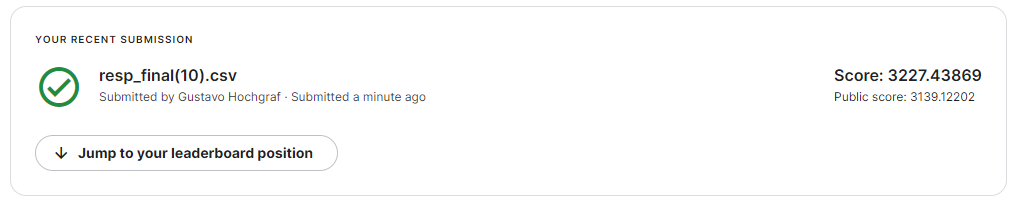